**DDIM, PROMPT-BASED EDITING AND LATENT NOISE INJECTION**

This notebook explores a set of preliminary experiments for modifying plant field imagery using **latent-level interventions** in the **DDIM (Denoising Diffusion Implicit Models)** generative process.

DDIM allows us to map an image back to its latent state and resume generation from any intermediate step.

We leverage this property to perform semantic editing:
- First, we invert an image into latents.
- Then, we resume generation with a new prompt, enabling visual changes (e.g., soil type, weed density) while preserving the image’s structure.

Additionally, we experiment with noise injection in latent space to introduce controlled variability:
- Injecting Gaussian or sparse noise into inverted latents allows for global or localized changes.
- This results in multiple coherent image variants from a single source image—useful for data augmentation.


*Library Imports and Initial Setup*

In [ ]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
# Load a pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
# Set up a DDIM scheduler
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
input_image = Image.open("06-05_00200_P0038053.png").convert("RGB")

This function implements a custom sampling loop based on DDIM (Denoising Diffusion Implicit Models), allowing fine control over the generation process. Instead of using the default pipe.scheduler.step(...), the update step is manually computed to allow for greater flexibility —such as restarting from intermediate latents.

Key features:
- Accepts a custom starting point (start_latents) and resumes generation from a given start_step.
- Applies classifier-free guidance.
- Enables consistent and controllable image generation, useful for editing and experimentation.

In [ ]:
# Sample function (regular DDIM)
@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None,
           guidance_scale=3.5, num_inference_steps=30,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
    
        t = pipe.scheduler.timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves:
        prev_t = max(1, t.item() - (1000//num_inference_steps)) # t-1
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1-alpha_t).sqrt()*noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1-alpha_t_prev).sqrt()*noise_pred
        latents = alpha_t_prev.sqrt()*predicted_x0 + direction_pointing_to_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

This function performs approximate inversion of an image using the DDIM process. Given a latent representation of an image (obtained via VAE encoding), it reconstructs the sequence of latent states that would have produced that image during forward generation.

Key points:
- Runs the DDIM denoising process in reverse, from t = T down to t = 0.
- Stores the intermediate latent states, allowing us to later resume generation from any step.
- Enables applications such as prompt-based editing, latent manipulation, or controlled image regeneration.

In [ ]:
## Inversion
@torch.no_grad()
def invert(start_latents, prompt, guidance_scale=3.5, num_inference_steps=80,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps-1):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1: continue

        t = timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000//num_inference_steps)) #t
        next_t = t # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1-alpha_t).sqrt()*noise_pred)*(alpha_t_next.sqrt()/alpha_t.sqrt()) + (1-alpha_t_next).sqrt()*noise_pred

        # Store
        intermediate_latents.append(latents)
            
    return torch.cat(intermediate_latents)

This function enables semantic editing of an input image by combining DDIM inversion and prompt substitution.

Workflow:
- The input image is encoded into latent space using the model’s VAE.
- The latent is inverted via DDIM to recover the denoising trajectory.
- From an intermediate latent step (start_step), the generation process resumes — but with a new textual prompt.

This allows for modifying the image’s semantic content (e.g., field condition, vegetation) while preserving its spatial layout and structure.

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

/root/.local/share/mamba/envs/cv/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:458: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


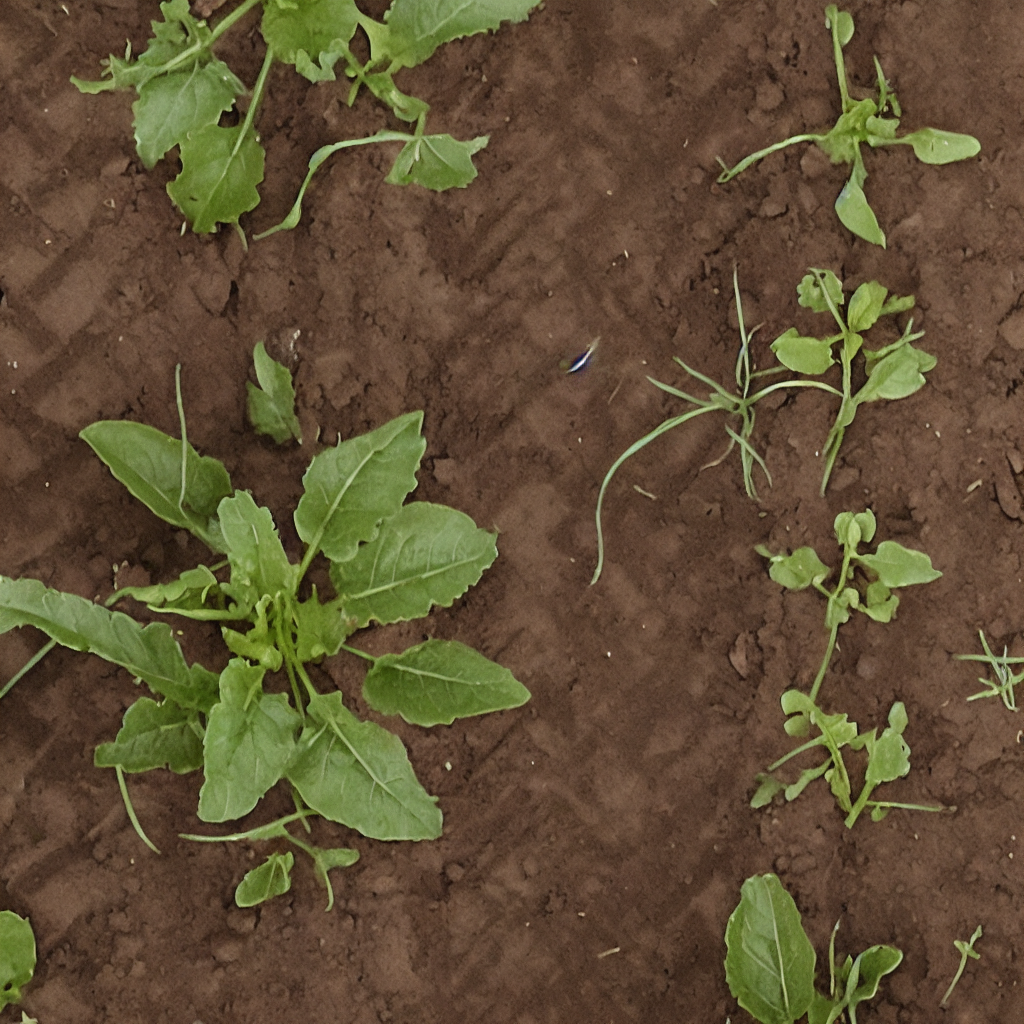

In [42]:
def edit_with_prompt(input_image, input_image_prompt, edit_prompt, num_steps=100, start_step=30, guidance_scale=3.5):
    with torch.no_grad():
        latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = invert(l, input_image_prompt, num_inference_steps=num_steps)
    final_im = sample(
        edit_prompt,
        start_latents=inverted_latents[-(start_step + 1)][None],
        start_step=start_step,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
    )[0]
    return final_im

edit_prompt = "Crops and weeds in a sandy field under cloudy sky"
edit_with_prompt(input_image, "Aerial view of a crop field", edit_prompt, num_steps=100, start_step=40, guidance_scale=3.5)

This function introduces controlled variability by injecting noise into the inverted latent representation of an input image, and then regenerating it using a new prompt.

Key steps:
- The input image is encoded and inverted via DDIM to obtain a sequence of latent states.
- A specific latent (based on start_step) is selected.
- Gaussian or sparse noise is added to this latent to introduce subtle or localized changes.
- The generation process resumes from that noisy latent using the edited prompt.

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

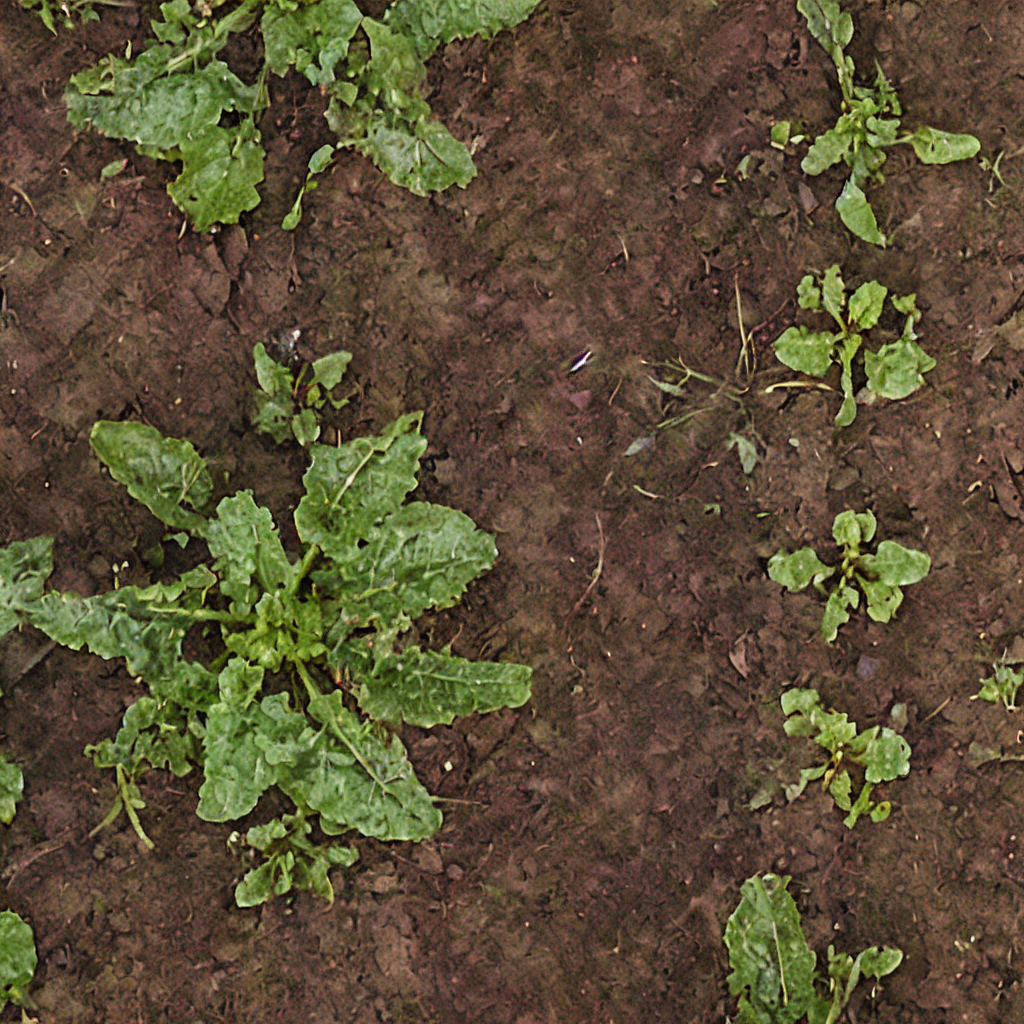

In [ ]:
def noise_injection(input_image, input_image_prompt, edit_prompt, 
                    num_steps=100, start_step=60, guidance_scale=3.5,
                    noise_strength=0.2, noise_type='gaussian'):
    # Original image to latents
    with torch.no_grad():
        latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    l = 0.18215 * latent.latent_dist.sample()
    
    # Inversion
    inverted_latents = invert(l, input_image_prompt, num_inference_steps=num_steps)
    
    # Noise injection
    noise_target = inverted_latents[-(start_step + 1)][None].clone()
    
    if noise_type == 'gaussian':
        noise = torch.randn_like(noise_target) * noise_strength
    elif noise_type == 'sparse':
        noise = torch.zeros_like(noise_target)
        # Adds noise to only 10% of random pixels
        mask = torch.rand_like(noise) < 0.1
        noise[mask] = torch.randn(mask.sum()) * noise_strength * 3  # More intense

    noisy_latents = noise_target + noise
    
    # Final sampling with noise
    final_im = sample(
        edit_prompt,
        start_latents=noisy_latents,  
        start_step=start_step,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
    )[0]
    
    return final_im

noise_injection(
    input_image, 
    input_image_prompt="Aerial view of crops and some weeds",
    edit_prompt="Crops and weeds in a brown field under cloudy sky",
    noise_strength=0.3,  
    noise_type='gaussian'  # 'sparse' for sparse noise
)

This function performs latent noise injection without using any textual guidance. It generates new image variations based solely on the structure encoded in the original image’s latents and the model’s learned priors.

Procedure:
- The input image is encoded and inverted using an empty prompt, ensuring no semantic conditioning.
- Noise is injected into a selected intermediate latent state (based on start_step).
- The generation process resumes unconditionally, with a guidance scale of 1.0.

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

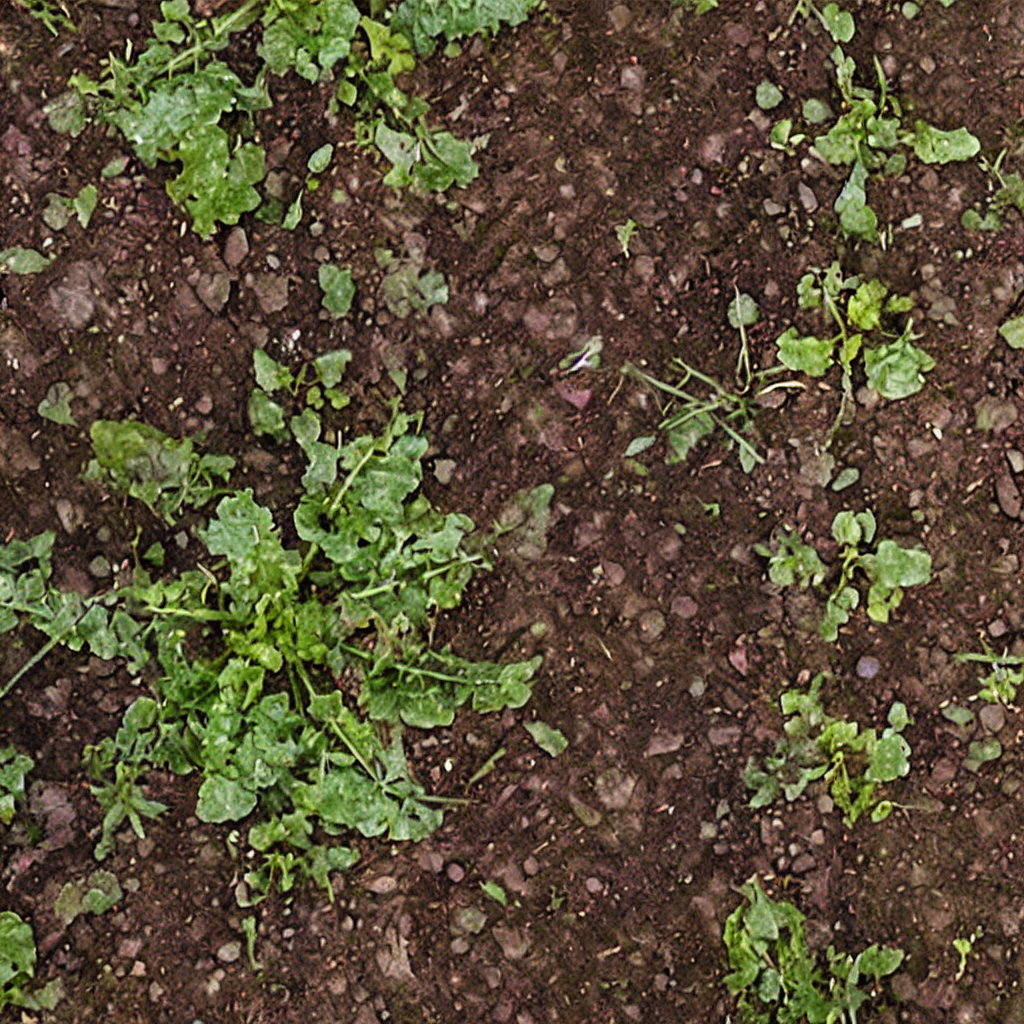

In [ ]:
def noise_injection_unconditional(input_image, num_steps=100, start_step=45, 
                                noise_strength=0.2, noise_type='gaussian'):
    with torch.no_grad():
        latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    l = 0.18215 * latent.latent_dist.sample()
    
    # Inversion without prompt
    inverted_latents = invert(l, "", num_inference_steps=num_steps)
    
    # Noise injection
    noise_target = inverted_latents[-(start_step + 1)][None].clone()
    
    if noise_type == 'gaussian':
        noise = torch.randn_like(noise_target) * noise_strength
    elif noise_type == 'sparse':
        noise = torch.zeros_like(noise_target)
        mask = torch.rand_like(noise) < 0.1  
        noise[mask] = torch.randn(mask.sum()) * noise_strength * 3
    
    noisy_latents = noise_target + noise

    # Final sampling without prompt (guidance scale=1.0)
    final_im = sample(
    "",  # Empty prompt
    start_latents=noisy_latents,
    start_step=start_step,
    num_inference_steps=num_steps,
    guidance_scale=1.0,
    do_classifier_free_guidance=True,  # Keep it True
    negative_prompt=""  # Empty negative prompt
    )[0]
    
    return final_im


noise_injection_unconditional(
    input_image,
    noise_strength=0.3,
    noise_type='gaussian'  
)